In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re

In [65]:
# Training Parameters
learning_rate = 0.5
training_steps = 10000
#batch_size = 128
display_step = 200

# Network Parameters
num_input = 39 # MNIST data input (img shape: 28*28)
timesteps = 100 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [88]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 0:39])
#     print(data_x.shape)
    
    data_y = np.array(dataset.iloc[:, 40:41])
#     print(data_y.shape)

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    for i in range(len(all_foot)):
        strike_times.append([float(all_time[i]), all_foot[i]])
#     print(len(strike_times))

    # left - 0, right = 1
    strike_times.append([length/25.0, 'E'])
    step_direct = 0
    window_y = []
    strike_index=0
    for i in range(length):
        if(strike_index<len(strike_times) and i/25.0 < strike_times[strike_index][0]):
            window_y.append([step_direct])
        else:
            step_direct = 1-step_direct
            strike_index += 1
            window_y.append([step_direct])
            
    return window_y

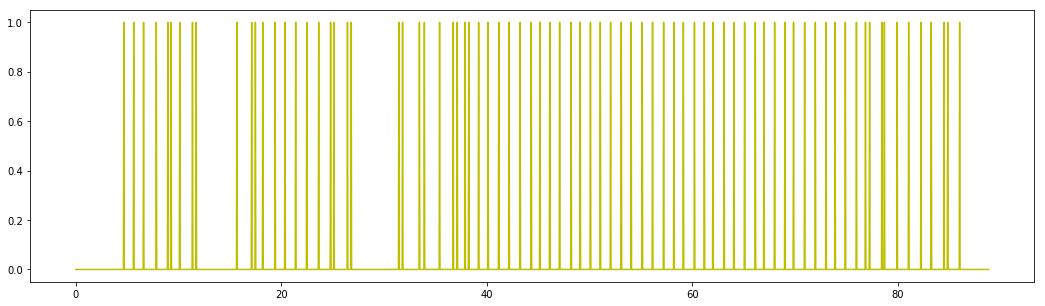

In [89]:
data_x_1, data_y_1 = read_sensor('weallwalk/T1_ID1_1L_GD_iPhoneSensors.csv')

plt.figure(figsize=(18, 5))
#plt.plot([i for i in range(0,1000)], [i[0] for i in rand_x], 'b')
plt.plot([i[0] for i in data_x_1], [i[0] for i in data_y_1], 'y')
plt.show()

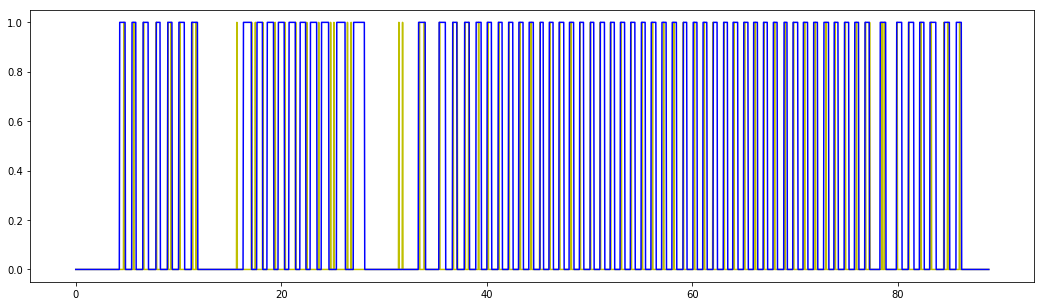

In [90]:
window_y_1 = read_xml('weallwalk/T1_ID1_GD.xml', len(data_x_1))
        
# print window_y
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_1], [i[0] for i in data_y_1], 'y')
plt.plot([i[0] for i in data_x_1], [i[0] for i in window_y_1], 'b')
#plt.plot([i[0] for i in data_x], [i[6] for i in data_x], 'r')
plt.show()

2749


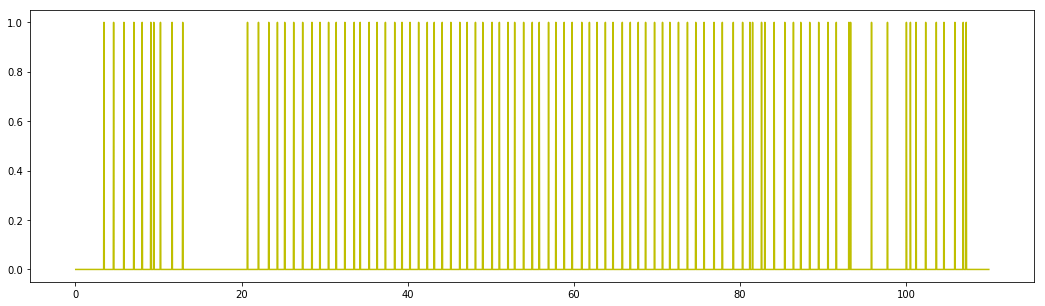

In [91]:
data_x_2, data_y_2 = read_sensor('weallwalk/T2_ID1_1L_GD_iPhoneSensors.csv')
print(len(data_x_2))

plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_2], [i[0] for i in data_y_2], 'y')
plt.show()  

2749


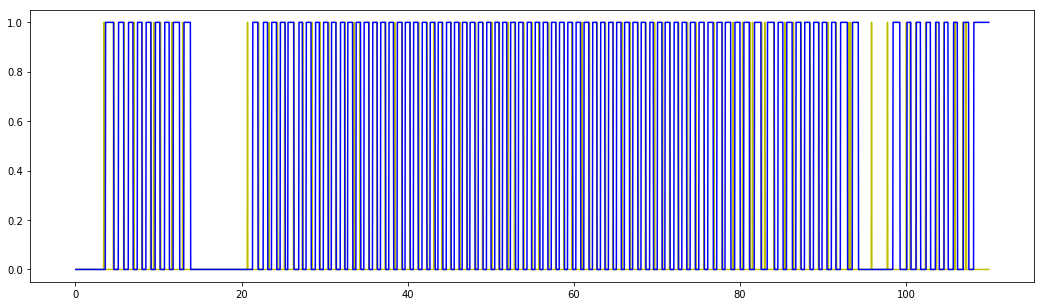

In [92]:
window_y_2 = read_xml('weallwalk/T2_ID1_GD.xml', len(data_x_2))
print(len(window_y_2))
        
# print window_y
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in data_x_2], [i[0] for i in data_y_2], 'y')
plt.plot([i[0] for i in data_x_2], [i[0] for i in window_y_2], 'b')
plt.show()

In [93]:
train_x,train_y=[],[] 
for i in range(len(data_x_1)-timesteps):
    x=data_x_1[i:i+timesteps]
    y=window_y_1[i+timesteps]
    train_x.append(x)
    train_y.append(y)

test_x,test_y=[],[] 
for i in range(len(data_x_2)-timesteps):
    x=data_x_2[i:i+timesteps]
    y=window_y_2[i+timesteps]
    test_x.append(x)
    test_y.append(y)
    
print(len(train_y))
print(len(test_y))

2122
2649


In [94]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [95]:
training_steps = 10001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(training_steps):
        feed_dict = {X: train_x, Y: train_y}
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 6.425064
Loss at step 200: 0.188566
Loss at step 400: 0.116482
Loss at step 600: 0.083810
Loss at step 800: 0.058973
Loss at step 1000: 0.049790
Loss at step 1200: 0.041485
Loss at step 1400: 0.035904
Loss at step 1600: 0.034654
Loss at step 1800: 0.032595
Loss at step 2000: 0.029938
Loss at step 2200: 0.020423
Loss at step 2400: 0.015314
Loss at step 2600: 0.015077
Loss at step 2800: 0.018919
Loss at step 3000: 0.009048
Loss at step 3200: 0.006764
Loss at step 3400: 0.008455
Loss at step 3600: 0.014561
Loss at step 3800: 0.003518
Loss at step 4000: 0.021999
Loss at step 4200: 0.007454
Loss at step 4400: 0.020407
Loss at step 4600: 0.002103
Loss at step 4800: 0.001381
Loss at step 5000: 0.001117
Loss at step 5200: 0.018173
Loss at step 5400: 0.008116
Loss at step 5600: 0.000774
Loss at step 5800: 0.000662
Loss at step 6000: 0.000762
Loss at step 6200: 0.001124
Loss at step 6400: 0.000408
Loss at step 6600: 0.169963
Loss at step 6800: 0.014803
Loss at step 70

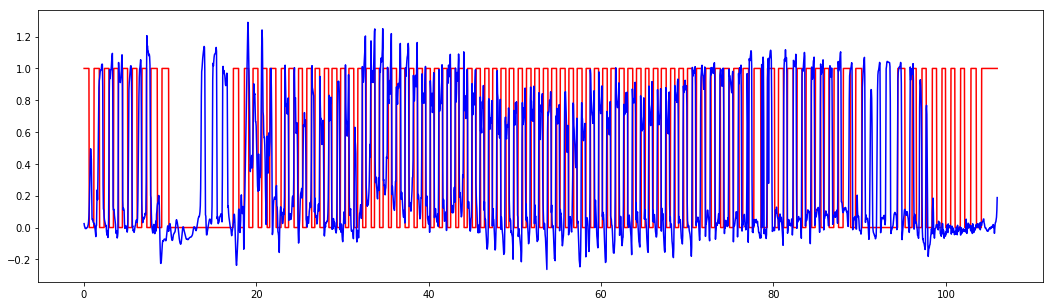

In [96]:
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in test_x], [i[0] for i in test_y], 'r')
plt.plot([i[0][0] for i in test_x], [i[0] for i in test_logits], 'b')
plt.show()

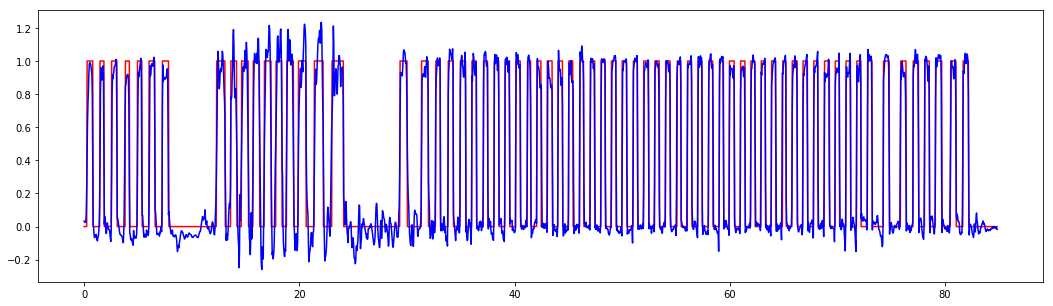

In [97]:
plt.figure(figsize=(18, 5))
plt.plot([i[0][0] for i in train_x], [i[0] for i in train_y], 'r')
plt.plot([i[0][0] for i in train_x], [i[0] for i in predictions], 'b')
plt.show()